In [1]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax
import distrax

from nnp_functions.pf_vehicle import PFVehicle
from nnp_functions.particle_filter import ParticleFilter
from nnp_functions.neural_networks import MixFeedForwardNetwork, MixMultiChannelNetwork, MixGivFeedForwardNetwork


# NAR1 Experiment

## Static Experiment Constants.

In [2]:
TAU = 0.4 / (256)
KAPPA = 12
X_BAR = jnp.log(0.16)
SIGMA_SIGMA = 6.4

# Train and eval constants.
TRAIN_KEY = jax.random.key(112)
TRAIN_BATCH_SIZE = 1000
TRAIN_STEPS = 2500

EVAL_N_RUNS = 1000
EVAL_N_TIMESTEPS = 5000
EVAL_DATA_KEY = jax.random.key(65)

# NN Model Parameters
N_MIX = 3
MODEL_SIZES = [
    # (1, 4),
    # (1, 16),
    # (1, 64),
    (2, 16),
    (3, 64),
]

## Model Definiton Functions

In [3]:
SIGMA_Y = 3.2 * jnp.sqrt(TAU)

def f_mean_func(last_val):
    return last_val + TAU * KAPPA * (X_BAR - last_val)

def f_std_func(last_val):
    return jnp.sqrt(TAU) * SIGMA_SIGMA

def g_mean_func(last_val):
    return jnp.exp(last_val)

def g_std_func(last_val):
    return SIGMA_Y


### Creating the state functions from the above.

In [4]:
def f_from_noise(last_val, noise):
    """
    Evolve the hidden state using the stochastic volatility model.
    
    Args:
        last_val: Previous hidden state value
        noise: Random noise for the evolution
        
    Returns:
        next_val: Next hidden state value
    """
    means = f_mean_func(last_val)
    std = f_std_func(last_val)
    
    return noise * std + means

def f_sample_fn(subkey, particles, Y_array, idt):
    return f_from_noise(particles, jax.random.normal(subkey, len(particles)))
    

def g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """
    y_means = g_mean_func(all_particles)
    y_stds = g_std_func(all_particles)
    
    return y_means + (total_noise * y_stds)

def f_likelihood_single(
        particle: float, prev_particle: float, Y_array, idt
        ) -> float: 
    """
    Calculate the transition probability density for the stochastic volatility model.
    
    Parameters:
    -----------
    particle : float
        Current particle state (log volatility)
    prev_particle : float
        Previous particle state (log volatility)
        
    Returns:
    --------
    float
        Log probability density of the transition from prev_particle to particle
    """
    
    # Calculate transition parameters
    f_means = f_mean_func(prev_particle)  # Mean reversion
    f_std = f_std_func(prev_particle)  # Transition noise scale
    
    # Calculate log probability density
    f_x_given_x_prev = jsp.stats.norm.logpdf(particle, f_means, f_std)
    
    return f_x_given_x_prev 

def g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    mean = g_mean_func(prev_particle)  # expected mean
    std = g_std_func(prev_particle)  # full variance
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), mean, std)

g_likelihood_weight_fn = jax.vmap(g_likelihood_single, in_axes=(0, 0, None, None))

def transition_model(input):
    last_x, y = input
    mean = f_mean_func(last_x)
    scale = f_std_func(last_x)
    return mean, scale


In [5]:
def mix_model_sample_from_inputs(model, subkey, inputs):
    means, scales, weights = model(inputs)

    mix = distrax.MixtureSameFamily(
        mixture_distribution=distrax.Categorical(probs=weights),
        components_distribution=distrax.Normal(loc=means, scale=scales)
    )
    return mix.sample(subkey)

def mix_model_weight_from_inputs(model, particles, inputs):
    means, scales, weights = model(inputs)

    mix = distrax.MixtureSameFamily(
        mixture_distribution=distrax.Categorical(probs=weights),
        components_distribution=distrax.Normal(loc=means, scale=scales)
    )
    return mix.log_prob(particles)

### Creating the Vehicle and Particle Filter.

In [6]:
stoch_vol_vehicle = PFVehicle(f_from_noise, g_from_total_noise, f_likelihood_single, g_likelihood_single)
stoch_vol_vehicle.model_sample_from_inputs = mix_model_sample_from_inputs
stoch_vol_vehicle.model_weight_from_inputs = mix_model_weight_from_inputs

stoch_bootstrap_pf = ParticleFilter(f_sample_fn, g_likelihood_single)

# Generate test data for evaluation

print(f"Generating {EVAL_N_RUNS} runs of data with {EVAL_N_TIMESTEPS} timesteps each...")
test_input_batches, test_target_batches = stoch_vol_vehicle.generate_training_data(
    EVAL_DATA_KEY, 
    EVAL_N_RUNS,
    EVAL_N_TIMESTEPS,
    X_BAR
)

test_inputs = jnp.vstack(test_input_batches)
test_targets = jnp.hstack(test_target_batches)

# Defining the loss function
def boot_loss(model, inputs, z_i):
    log_likelihood = jax.vmap(PFVehicle.model_weight_from_inputs, in_axes=(None, 0, 0))(model, z_i, inputs)
    return -jnp.mean(log_likelihood)

def loss(model, inputs, z_i):
    log_likelihood = jax.vmap(stoch_vol_vehicle.model_weight_from_inputs, in_axes=(None, 0, 0))(model, z_i, inputs)
    return -jnp.mean(log_likelihood)

# Evaluating the Bootstrap Model:
boot_eval = boot_loss(transition_model, test_inputs, test_targets)
print(boot_eval)

Generating 1000 runs of data with 5000 timesteps each...
0.044031523


[[ 0.22736195  0.0822586   0.22058858 ...  0.13098845 -0.03206177
   0.0276877 ]
 [ 0.11700556  0.21850725  0.25350553 ...  0.32949355  0.49261993
   1.1889808 ]
 [ 0.01842445  0.05343495 -0.00614089 ...  0.09576346  0.04617746
   0.13736977]]


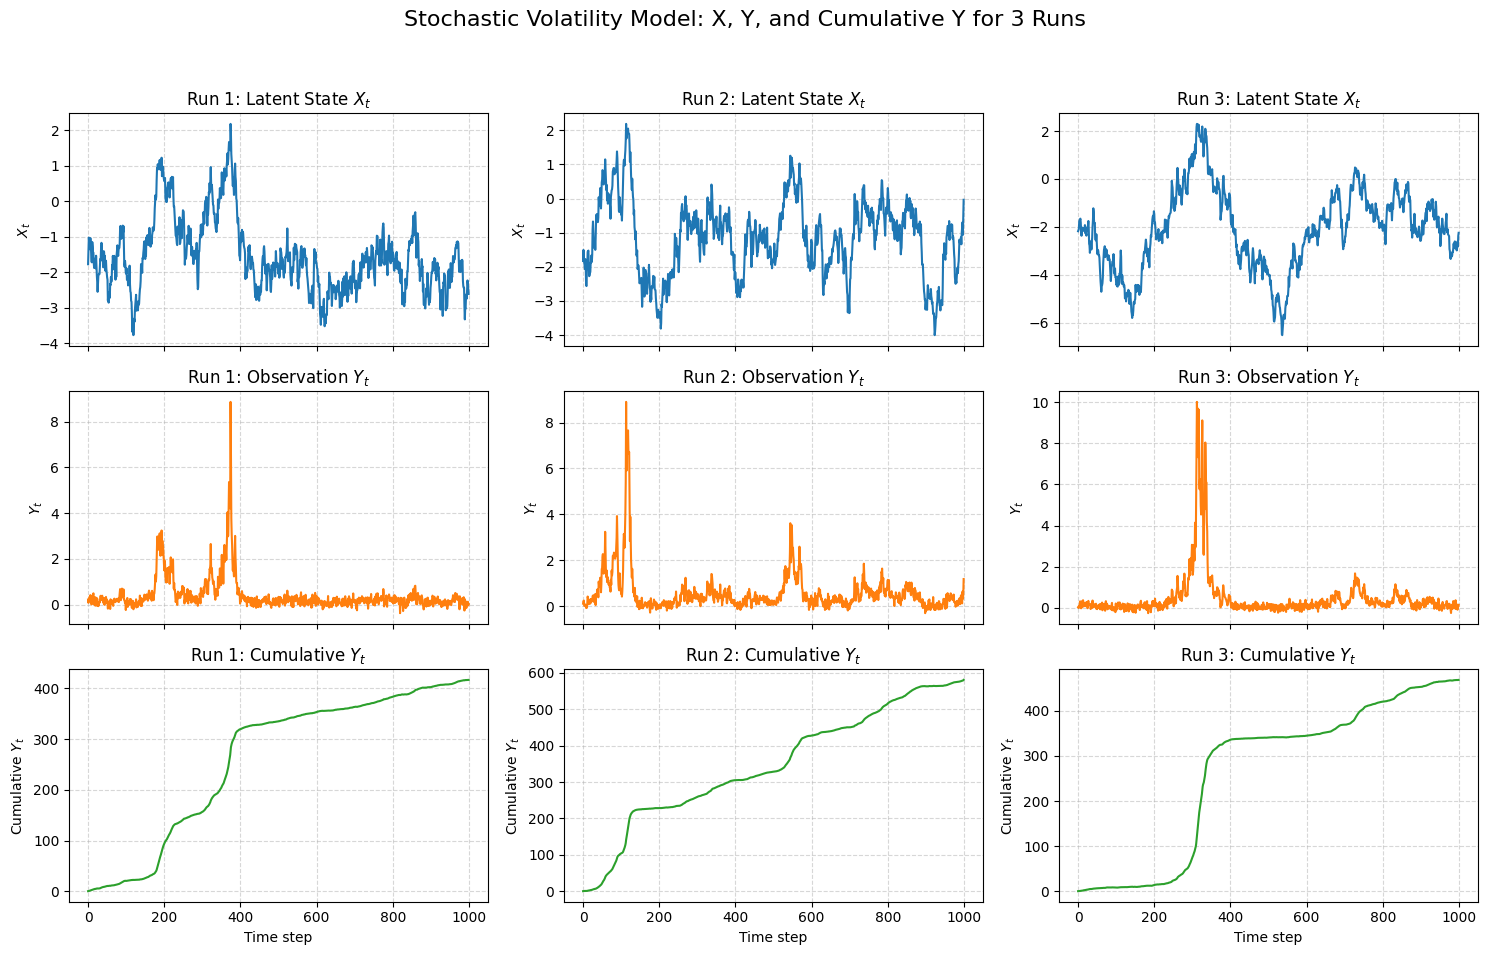

In [7]:
import matplotlib.pyplot as plt

plot_key = jax.random.key(100)
X, Y = stoch_vol_vehicle.generate_data(plot_key, 3, 1000, X_BAR)
print(Y)

fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
fig.suptitle("Stochastic Volatility Model: X, Y, and Cumulative Y for 3 Runs", fontsize=16)

for i in range(3):
    # Plot X
    axes[0, i].plot(X[i], color='tab:blue')
    axes[0, i].set_title(f"Run {i+1}: Latent State $X_t$")
    axes[0, i].set_ylabel("$X_t$")
    axes[0, i].grid(True, linestyle='--', alpha=0.5)
    
    # Plot Y
    axes[1, i].plot(Y[i], color='tab:orange')
    axes[1, i].set_title(f"Run {i+1}: Observation $Y_t$")
    axes[1, i].set_ylabel("$Y_t$")
    axes[1, i].grid(True, linestyle='--', alpha=0.5)
    
    # Plot cumulative Y
    axes[2, i].plot(jnp.cumsum(Y[i]), color='tab:green')
    axes[2, i].set_title(f"Run {i+1}: Cumulative $Y_t$")
    axes[2, i].set_xlabel("Time step")
    axes[2, i].set_ylabel("Cumulative $Y_t$")
    axes[2, i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Training the models.


Training MultiChannel model 1/2: n_layers=2, hidden_dim=16


  0%|          | 0/2500 [00:00<?, ?it/s]

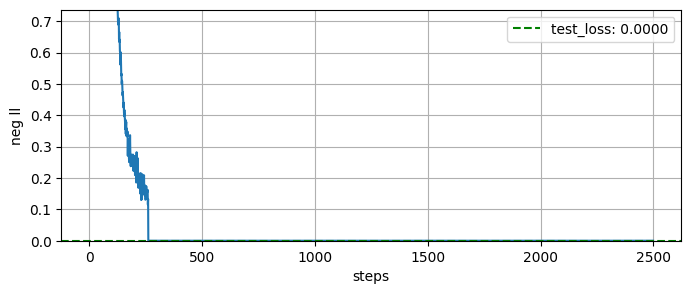


Training MultiChannel model 2/2: n_layers=3, hidden_dim=64


  0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
# Training the Multi Channel Network.

trained_multich_models_evals = {}

def nice_log(x):
    return jnp.log(jnp.abs(x) + 1e-24)

for i, (n_layers, hidden_dim) in enumerate(MODEL_SIZES):
    print(f"\nTraining MultiChannel model {i+1}/{len(MODEL_SIZES)}: n_layers={n_layers}, hidden_dim={hidden_dim}")
    
    multi_model = MixGivFeedForwardNetwork(n_layers, hidden_dim, N_MIX, nice_log, jax.random.key(200 + i))
    stoch_vol_vehicle.train_model(
        TRAIN_KEY, 
        multi_model,
        TRAIN_BATCH_SIZE, 
        learning_rate=1e-3,
        steps = TRAIN_STEPS, 
        X_bar = X_BAR,
        noise_starting_scale=3
    )

    multi_model_eval = loss(stoch_vol_vehicle.unvectorized_model, test_inputs, test_targets)
    trained_multich_models_evals[(n_layers, hidden_dim)] = multi_model_eval


Training model 1/2: n_layers=2, hidden_dim=16


  0%|          | 0/2500 [00:00<?, ?it/s]

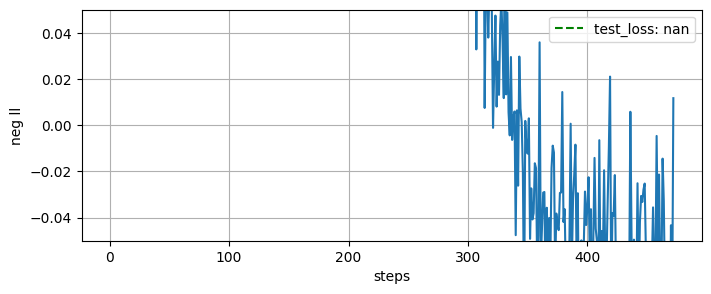


Training model 2/2: n_layers=3, hidden_dim=64


  0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Training the Feed Forward Network.

trained_models_evals = {}

for i, (n_layers, hidden_dim) in enumerate(MODEL_SIZES):
    print(f"\nTraining model {i+1}/{len(MODEL_SIZES)}: n_layers={n_layers}, hidden_dim={hidden_dim}")
    
    model = MixFeedForwardNetwork(n_layers, hidden_dim, N_MIX, jax.random.key(100 + i))
    stoch_vol_vehicle.train_model(
        TRAIN_KEY, 
        model,
        TRAIN_BATCH_SIZE, 
        learning_rate=1e-3,
        steps = TRAIN_STEPS, 
        X_bar = X_BAR,
    )

    model_eval = loss(stoch_vol_vehicle.unvectorized_model, test_inputs, test_targets)
    trained_models_evals[(n_layers, hidden_dim)] = model_eval


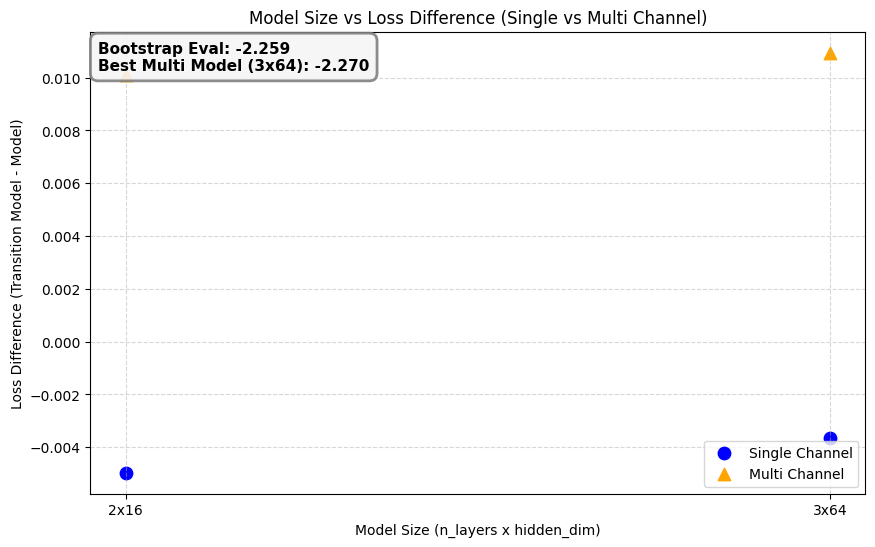

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for scatter plot for single-channel model
model_sizes_list = list(trained_models_evals.keys())
model_losses = [trained_models_evals[size] for size in model_sizes_list]
loss_diffs = [boot_eval - loss for loss in model_losses]
model_size_labels = [f"{n_layers}x{hidden_dim}" for (n_layers, hidden_dim) in model_sizes_list]

# Prepare data for scatter plot for multi-channel model
multich_model_sizes_list = list(trained_multich_models_evals.keys())
multich_model_losses = [trained_multich_models_evals[size] for size in multich_model_sizes_list]
multich_loss_diffs = [boot_eval - loss for loss in multich_model_losses]
multich_model_size_labels = [f"{n_layers}x{hidden_dim}" for (n_layers, hidden_dim) in multich_model_sizes_list]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(model_size_labels, loss_diffs, color='blue', s=80, label='Single Channel')
ax.scatter(multich_model_size_labels, multich_loss_diffs, color='orange', s=80, marker='^', label='Multi Channel')

ax.set_xlabel("Model Size (n_layers x hidden_dim)")
ax.set_ylabel("Loss Difference (Transition Model - Model)")
ax.set_title("Model Size vs Loss Difference (Single vs Multi Channel)")
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()

# Find best model (lowest loss) among all models
all_losses = model_losses + multich_model_losses
all_labels = model_size_labels + multich_model_size_labels
all_types = ['Single'] * len(model_losses) + ['Multi'] * len(multich_model_losses)
if all_losses:  # avoid error if empty
    best_idx = int(np.argmin(all_losses))
    best_label = all_labels[best_idx]
    best_loss = all_losses[best_idx]
    best_type = all_types[best_idx]
    # Find the x and y coordinates for the best model
    if best_idx < len(model_size_labels):
        x_coord = model_size_labels[best_idx]
        y_coord = loss_diffs[best_idx]
    else:
        x_coord = multich_model_size_labels[best_idx - len(model_size_labels)]
        y_coord = multich_loss_diffs[best_idx - len(model_size_labels)]
    # Compose the annotation text for both bootstrap and best model
    annotation_text = (
        f'Bootstrap Eval: {boot_eval:.3f}\n'
        f'Best {best_type} Model ({best_label}): {best_loss:.3f}'
    )
    # Place the annotation in a single box on the plot (upper left)
    ax.annotate(
        annotation_text,
        xy=(0.01, 0.98), xycoords='axes fraction',
        xytext=(0, 0), textcoords='offset points',
        bbox=dict(boxstyle="round,pad=0.5", fc="whitesmoke", ec="gray", lw=2, alpha=0.9),
        color='black', fontsize=11, fontweight='bold',
        ha='left', va='top'
    )

plt.show()
